### By default
case 1:
- Amplitude 0.1, 30 sets, uniform distribution with (0.05, 0.1, 30), with noise amp of 0.01

case 2:
- Amplitude 0.1, 30 sets, Normal distribution with (1, 0.5, 30), with noise amp of 0.01

case 3:


In [ ]:
currentAmp = 1
sets = 15
# noiseSD = 0.01

In [ ]:
#@title Distribution
from ipywidgets import FloatText, Checkbox, VBox, Dropdown
import ipywidgets as widgets

distribution = Dropdown(description='distribution:', options=["uniform", "normal", "poisson"], value="uniform")
low = FloatText(description='low:', value=0.05)
high = FloatText(description='high:', value=0.1)
leng = FloatText(description='size:', value=sets.value)
mean = FloatText(description='mean:', value=1)
sd = FloatText(description='SD:', value=0.5)
lam = FloatText(description='lam', value=3)

vb2 = VBox(children = [low, high, leng])

def change_widgets(button):
    if button['new'] == "uniform":
        vb2.children = [low, high, leng]
    elif button['new'] == "normal":
        vb2.children = [mean, sd, leng]
    elif button['new'] == "poisson":
        vb2.children = [lam, sets]

distribution.observe(change_widgets, names='value')
display(distribution)
display(vb2)

Dropdown(description='distribution:', options=('uniform', 'normal', 'poisson'), value='uniform')

In [ ]:
#@title Set Delays
delayP1P2 = 0.1 #@param {type:"number"}
delayP2P1 =  0.3#@param {type:"number"}

# References

References:

1) https://www.neuron.yale.edu/neuron/static/new_doc/programming/hocsyntax.html

2) https://www.neuron.yale.edu/neuron/static/new_doc/programming/python.html

3) https://www.neuron.yale.edu/neuron/static/py_doc/programming/python.html

4) https://www.geeksforgeeks.org/single-neuron-neural-network-python/

5) https://github.com/piazentin/ksets

6) AP - https://www.moleculardevices.com/applications/
patch-clamp-electrophysiology/what-action-potential#gref

7) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html

8) http://neupy.com/apidocs/neupy.algorithms.associative.hebb.html

9) https://qbi-software.github.io/NEURON-tutorial/lessons/network

10) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/topology/geometry.html

11) http://www.cnel.ufl.edu/courses/EEL6814/chapter6.pdf

12) https://www.slideshare.net/mentelibre/hebbian-learning

13) http://www.diva-portal.org/smash/get/diva2:1089220/FULLTEXT02

# Stage 1:Importing required libraries

In [ ]:
pip install neuron

In [ ]:
import time
totalstart = time.time()
import os
if os.getcwd() != "/content":
    # we are not in google colab, assume hebbian library is in current dir
    from hebb import ORN, MCELL, GCELL
else:
    # download from git
    import shutil, requests
    url = 'https://cloud.operationtulip.com/s/t8nbn8Y582w94P3/download/git.zip'
    response = requests.get(url, stream=True)
    with open('git.zip', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    import zipfile
    with zipfile.ZipFile('git.zip', 'r') as zip_ref:
        zip_ref.extractall('')
    from hebb_test import ORN, MCELL, GCELL

In [ ]:
from neuron import h                     #.h is a HOC object instanced & gui from neuron can also be imported 
from neuron.units import ms,mV
h.load_file('stdrun.hoc')                #Allows us to do a high level simulation
  
import matplotlib.pyplot as plt1

import numpy as np
from scipy.stats import poisson
import seaborn as sb

from bokeh.io import output_notebook
import bokeh.plotting as plt2
output_notebook()



# Helper Functions

In [ ]:
def stairstep(lo: float, hi: float, duration: int, max_duration: int = 200, noise: list = []) -> list:
    # duration and max_duration are in ms
    ans = [lo if i < duration else hi for i in range(0,max_duration)]
    if len(noise) == 0:
        return ans
    else:
        assert len(ans) == len(noise)
        return [ans[i]+noise[i] for i in range(len(ans))]
    # return [0+0.8*(i/duration) if i < duration else 0 for i in range(0,max_duration)]
    # visualize input 

In [ ]:
def netConMaker(source, dest, weights, delay, threshold, place='axon', type='exc'):
    if place == 'axon':
        if type == 'exc':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendexcisyn, sec=source.axon)
        elif type == 'inh':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendinhisyn, sec=source.axon)
    elif place == 'soma':
        if type == 'exc':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendexcisyn, sec=source.soma)
        elif type == 'inh':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendinhisyn, sec=source.soma)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [ ]:
def latConMaker(source, dest, weights, delay, threshold, type='exc'):
    if type == 'exc':
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendexcisyn, sec=source.dend)
    else:
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendinhisyn, sec=source.dend)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [ ]:
def plotCell(source, name, addendum=''):
    recording_cell = source
    cell_axon = h.Vector().record(recording_cell.axon(0.5)._ref_v)
    cell_dend = h.Vector().record(recording_cell.dend(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    h.finitialize(-70 * mV)
    h.continuerun(300 * ms)

    f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
    f.line(t, list(cell_axon), line_width=1,legend_label=name+' axon '+addendum,line_color='black')
    f.line(t, list(cell_dend), line_width=2,legend_label=name+' dendrite '+addendum,line_color='red', line_dash='dashed')
    plt2.show(f)

In [ ]:
import math
def generate_L_weight_delta(first, second):
    A_plus = 0.03
    A_minus = -0.0011
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

In [ ]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Weight Distribution

In [ ]:
import numpy as np
if distribution.value == "uniform":
    weights = np.random.uniform(low.value, high.value, 2*int(leng.value)-1)
elif distribution.value == "normal":
    weights = np.random.normal(mean.value, sd.value, 2*int(leng.value)-1)
elif distribution.value == "poisson":
    weights = np.random.poisson(lam.value, 2*int(leng.value)-1)

# Stage 4: Coupling a neuron according to Freeman's KI Set with the weights given above

In [ ]:
#Gives one 2 coupled neuron using freeman's topology in olfactory bulb
class CONNECTING:

    def __init__(self,M,weights,delay1=1,delay2=1):
        wMM=weights[0]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 0
        
        #Making 2 neurons
        self.cells=[]
        self.P1=MCELL(1,self.M)
        self.P2=MCELL(2,self.M)
        self.cells.append(self.P1)
        self.cells.append(self.P2)
        
        #Giving current pulse
        self.stim = h.IClamp(self.P1.dend(0.5))
        print(with_noise.value)
        if with_noise.value == True:
            self.noise = np.random.normal(0, noiseSD.value, 100)
            self.input = h.Vector(stairstep(0,currentAmp.value,10,100,self.noise))
            self.tv = h.Vector([i for i in range(100)])
            self.stim.delay = 10
            self.stim.dur = 100
            self.stim.amp = 0
            self.input.play(self.stim._ref_amp, self.tv, True) 
        else:
            self.stim.delay = 10
            self.stim.dur = 100
            self.stim.amp = currentAmp.value
        
                
        #Connecting P1 to P2
        self.nc1 = h.NetCon(self.P1.axon(0.5)._ref_v,self.P2.dendexcisyn,sec=self.P1.axon)   # P1.axon to P2.dend
        self.nc1.weight[0] = weights[M]
        print("mutual weight is ", weights[M])
        self.nc1.delay = delayP1P2 #tP1P2
        self.nc1.threshold = self.th
        
        #Connecting P2 to P1
        self.nc2 = h.NetCon(self.P2.axon(0.5)._ref_v,self.P1.dendexcisyn,sec=self.P2.axon)    #P2.axon to P1.dend
        self.nc2.weight[0] = weights[M]
        self.nc2.delay = delayP2P1 #tP2P1
        self.nc2.threshold = self.th    

            

**Stage 5: Laterally connect each set of 2 coupled neurons according to Freeman's KI Set**

In [ ]:
class LATERAL:

    def __init__(self,N,weights):
        wMML=weights
        #wMML=0.1
        
        self.N = N
        self.th = -70
        self.maindelay = 20
        self.sets = []
        c=0
        for i in range(N):
            self.sets.append(CONNECTING(i,weights))
        
        self.netConArr = []
        for r in range(0,N-1):
          #Connecting P1[0] to P1[1]
          # make a list for easier access
          netConList = []
          netConList.append(h.NetCon(self.sets[r].P1.axon(0.5)._ref_v, self.sets[r+1].P1.dendexcisyn,sec=self.sets[r].P1.axon))
          netConList[0].weight[0]  = wMML[r+N]
          print("Lateral weight is", wMML[r+N])
          netConList[0].delay = self.maindelay+1
          netConList[0].threshold = self.th

          netConList.append(h.NetCon(self.sets[r+1].P1.axon(0.5)._ref_v, self.sets[r].P1.dendexcisyn, sec=self.sets[r+1].P1.axon))
          netConList[1].weight[0] = wMML[r+N]
          netConList[1].delay = self.maindelay+2
          netConList[1].threshold = self.th

          self.netConArr.append(netConList)

          # exec(f"self.nc11_{r} = h.NetCon(getattr(self.sets[r].P1.axon(0.5), '_ref_v'), self.sets[1+r].P1.dendexcisyn,sec=self.sets[r].P1.axon)")
          # exec(f"self.nc11_{r}.weight[0] = wMML[r+N]")
          # print("lateral weight is", wMML[r+N])
          # exec(f"self.nc11_{r}.delay = self.maindelay+1")
          # exec(f"self.nc11_{r}.threshold = self.th")
          # exec(f"self.nc12_{r} = h.NetCon(getattr(self.sets[1+r].P1.axon(0.5), '_ref_v'), self.sets[r].P1.dendexcisyn,sec=self.sets[1+r].P1.axon)")
          # exec(f"self.nc12_{r}.weight[0] = wMML[r+N]")
          # #print(wMML[r+N])
          # exec(f"self.nc12_{r}.delay = self.maindelay+2")
          # exec(f"self.nc12_{r}.threshold = self.th")

**Stage 6: Input the number of 2 coupled sets required (which are all laterally connected)**

In [ ]:
#Give N value to get N no. of 2 coupled neurons laterally connected
size = int(sets.value)
given_input_from_user = size #  int(input('Enter the number of 2 coupled sets required: '))
L1=LATERAL(given_input_from_user,weights)
print(weights)

False
mutual weight is  0.09677752790080775
False
mutual weight is  0.07256015878485887
False
mutual weight is  0.07014961542229689
Lateral weight is 0.09488344243815258
Lateral weight is 0.091376559354132
[0.09677753 0.07256016 0.07014962 0.09488344 0.09137656]


# Stage 7: Visualize the topology of the neurons and the 3D space they are in. Also visualize the density mechanisms added to each neuron of a set

In [ ]:
# h.topology()

In [ ]:
from neuron import h, gui2
gui2.set_backend('jupyter')
ps = gui2.PlotShape()
ps.variable('v')
ps.show(0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
recording_cell = L1.sets[0].stim
graph = h.Vector().record(recording_cell._ref_i)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300*ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(graph), line_width=2,legend_label='Input',line_color='black')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

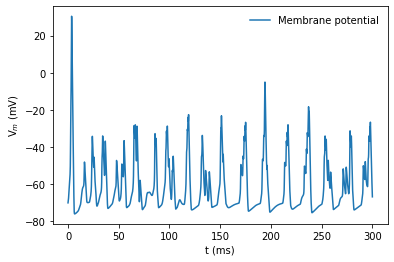

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

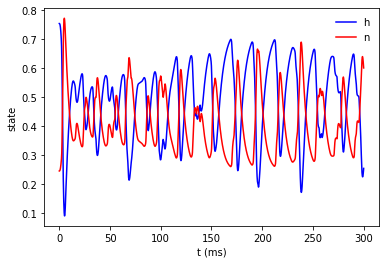

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

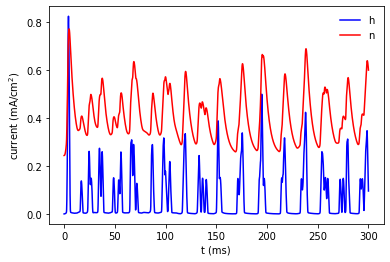

In [ ]:
import numpy as np
from matplotlib import pyplot

vvecAArr=[]
kvecAArr=[]
mvecAArr=[]
hvecAArr=[]
nvecAArr=[]
for i in L1.sets:
    for cell in i.cells:
        checkCell = cell.axon(0.5)
        vvecAArr.append(h.Vector().record(checkCell._ref_v))
        kvecAArr.append(h.Vector().record(checkCell.k_ion._ref_ik))
        # nvecA = h.Vector().record(checkCell.na_ion._ref_ina)
        mvecAArr.append(h.Vector().record(checkCell.hh._ref_m))
        hvecAArr.append(h.Vector().record(checkCell.hh._ref_h))
        nvecAArr.append(h.Vector().record(checkCell.hh._ref_n))

tvec = h.Vector().record(h._ref_t)

h.finitialize(-70)
h.continuerun(300)

vvecMean = np.mean(vvecAArr,axis=0)
hvecMean = np.mean(hvecAArr,axis=0)
nvecMean = np.mean(nvecAArr,axis=0)
kvecMean = np.mean(kvecAArr,axis=0)

fig = pyplot.figure()
pyplot.plot(tvec, vvecMean, label="Membrane potential")
pyplot.xlabel('t (ms)')
pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

fig = pyplot.figure()
pyplot.plot(tvec, hvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('state')
pyplot.legend(frameon=False)


fig = pyplot.figure()
pyplot.plot(tvec, kvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('current (mA/cm$^2$)')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

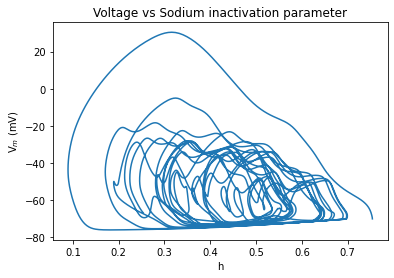

In [ ]:
fig = pyplot.figure()
pyplot.plot(hvecMean, vvecMean, label="")
pyplot.xlabel('h')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Sodium inactivation parameter')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


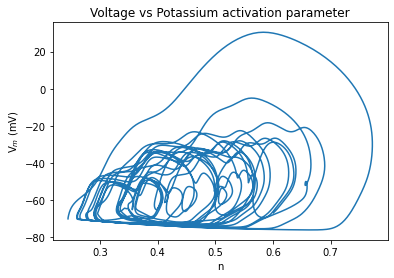

In [ ]:
fig = pyplot.figure()
pyplot.plot(nvecMean, vvecMean, label="")
pyplot.xlabel('n')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Potassium activation parameter')
pyplot.legend(frameon=False)

# Stage 8: Record & visualize the voltage values at each axon and dendrite

In [ ]:
recording_cell = L1.sets[2].P1
print("The voltage at P1's axon:", recording_cell.axon(0.5).v)
axon_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
print("The voltage at P1's dendrite:", recording_cell.dend(0.5).v)
dend_P1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P1 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P1 dend',line_color='red', line_dash='dashed')
plt2.show(f)

The voltage at P1's axon: -75.63048602926811
The voltage at P1's dendrite: -75.81758472005305


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
recording_cell = L1.sets[2].P2
axon_P2 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
dend_P2 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P2), line_width=1,legend_label='P2 axon',line_color='black')
f.line(t, list(dend_P2), line_width=2,legend_label='P2 dend',line_color='red', line_dash='dashed')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Scatter Plots of voltages

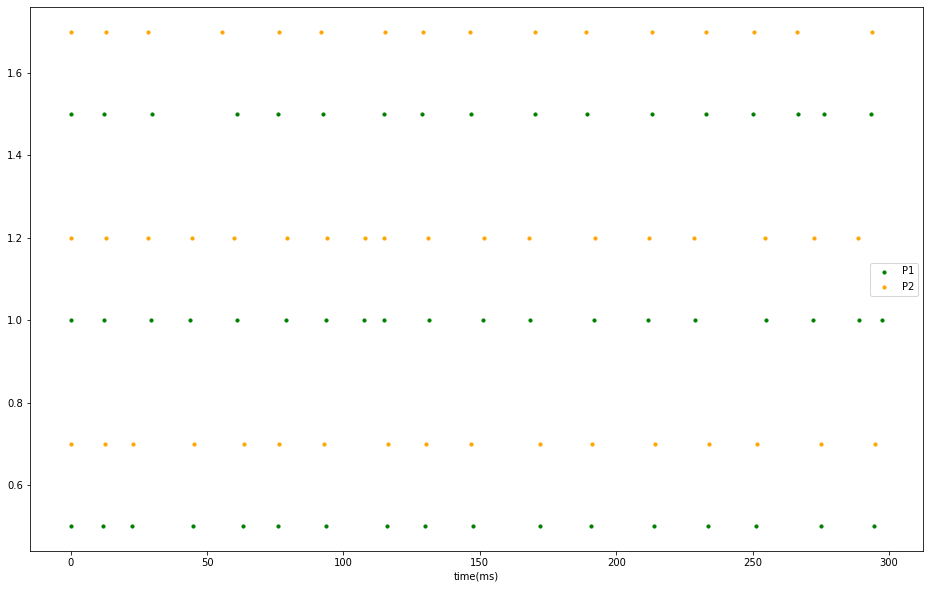

In [ ]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(len(L1.sets)):
  #for i,cell in enumerate(L1.sets[j].cells):
    plt1.scatter(L1.sets[j].cells[0].spike_times, [0.5 + 0.5*j for i in range(len(L1.sets[j].cells[0].spike_times))], s=10,color=color[0]) # for P1
    plt1.scatter(L1.sets[j].cells[1].spike_times, [0.7 + 0.5*j for i in range(len(L1.sets[j].cells[1].spike_times))], s=10, color=color[1])
plt1.xlabel('time(ms)')
plt1.legend(label)

In [ ]:
# color=['green','orange']
# label=['P1','P2']
# plt1.figure(figsize=(16,10))
# for j in range(1):
#   #for i,cell in enumerate(L1.sets[j].cells):
#     plt1.vlines(L1.sets[j].cells[0].spike_times+(100*j), 0.5, 1,color=color[0]) # for P1
#     plt1.vlines(L1.sets[j].cells[1].spike_times+(100*j), 0.5, 1, color=color[1])
# plt1.xlabel('time(ms)')
# plt1.legend(label)


In [ ]:
# color=['green','orange']
# label=['P2']
# plt1.figure(figsize=(16,11))
# for j in range(1):
#   #for i,cell in enumerate(L1.sets[j].cells):
#     plt1.vlines(L1.sets[j].cells[1].spike_times+(100*j), 1.5, 2,color=color[1]) # for P2
# plt1.xlabel('time(ms)')
# plt1.legend(label)

# Weights before learning

In [ ]:
%load_ext google.colab.data_table
import pandas
P1_spike_times = list(L1.sets[0].cells[0].spike_times)
P2_spike_times = list(L1.sets[0].cells[1].spike_times)

padding = len(P1_spike_times) - len(P2_spike_times)
P2_spike_times.extend([0 for i in range(padding)]) if padding > 0 else P1_spike_times.extend([0 for i in range(-padding)])
# print(len(P1_spike_times), len(P2_spike_times))
data = {'P1 before learning': P1_spike_times, 'P2 before learning' : P2_spike_times}
pandas.DataFrame(data)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,P1 before learning,P2 before learning
0,0.025,0.025
1,11.850,12.400
2,22.525,22.800
3,44.850,45.050
4,63.075,63.375
5,75.925,76.450
6,93.450,92.725
7,115.975,116.175
8,129.825,130.275
9,147.450,146.925


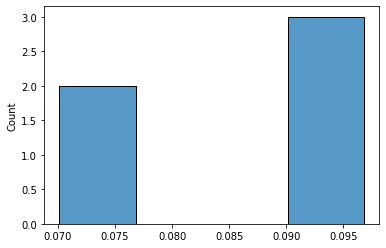

In [ ]:
sb.histplot(weights)

# Before learning Firing rate

In [ ]:
fr_P1=[0 for i in range(len(L1.sets))]
fr_P2=[0 for i in range(len(L1.sets))]
for f in range(len(L1.sets)):
  t=list(L1.sets[f].cells[0].spike_times)
  #print("spikes of p1", t)
  t1=list(L1.sets[f].cells[1].spike_times)
  #print("spikes of p2", t1)
  fr_P1[f]=(len(t)/100)*1000
  fr_P2[f]=(len(t1)/100)*1000
#print("frequencies of P1 in each set", fr_P1)
#print("frequencies of P2 in each set", fr_P2)

c=[0 for i in range(size*2)]
for i in range(size):
  c[i*2]=fr_P1[i]
  c[i*2+1]=fr_P2[i]
print("Frequencies of each neuron before learning", c)

Frequencies of each neuron before learning [170.0, 170.0, 190.0, 180.0, 170.0, 160.0]


# Population Activity (Before Learning)

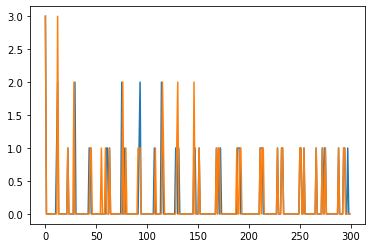

In [ ]:
resolution = 1
import numpy as np
import math
M1_spike_times = [0 for i in range(0,300,resolution)]
M2_spike_times = [0 for i in range(0,300,resolution)]
for cell in L1.sets:
    for i in list(cell.cells[0].spike_times):
        M1_spike_times[math.floor(i)] += 1
    for i in list(cell.cells[1].spike_times):
        M2_spike_times[math.floor(i)] += 1
# M2_spike_times = np.array([list(cell.cells[1].spike_times) for cell in L1.sets])

import matplotlib.pyplot as plt
plt.plot(M1_spike_times)
plt.plot(M2_spike_times)

In [ ]:
def generate_L_weight_delta(first, second):
    A_plus = 0.03
    A_minus = -0.0011
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

### **Stage 9:Learning**

In [ ]:
import sys, time
tick = time.time()
epochs = 30
weight_data1 = []
weight_data3 = []
weight_data5 = []

weight_data2 = []
weight_data4 = []
weight_data6 = []

out = display(progress(0, epochs), display_id=True)

for l in range(epochs):
    #print("iteration no is",l)
    out.update(progress(l, epochs))    
    # print("\nmutual learning")
    P1_axon_data = []
    P1_dend_data = []
    P2_axon_data = []
    P2_dend_data = []
    P1_spike_times = []
    P2_spike_times = []

    h.finitialize(-70* mV)
    h.continuerun(300*ms)
    t = h.Vector().record(h._ref_t)
    
    for i in range(len(L1.sets)):
        P1_axon_data.append(list(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)))
        P1_dend_data.append(list(h.Vector().record(L1.sets[i].P1.dend(0.5)._ref_v)))
        P1_spike_times.append(list(L1.sets[i].P1.spike_times))
        P2_axon_data.append(list(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v)))
        P2_spike_times.append(list(L1.sets[i].P2.spike_times))
        P2_dend_data.append(list(h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)))
   
    # h.finitialize(-70 * mV)

    for i in range(len(L1.sets)):
        # 2-coupled STDP-based learning
        L1.sets[i].nc1.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i])
        # logging
        
        # print("P1_axon", P1_spike_times[i], P2_spike_times[i])
        L1.sets[i].nc2.weight[0] += generate_L_weight_delta(P2_spike_times[i], P1_spike_times[i])
        
    # do a proper logging function
    weight_data1.append(L1.sets[0].nc1.weight[0])
    weight_data3.append(L1.sets[1].nc1.weight[0])
    weight_data5.append(L1.sets[2].nc1.weight[0])

    weight_data2.append(L1.sets[0].nc2.weight[0])
    weight_data4.append(L1.sets[1].nc2.weight[0])
    weight_data6.append(L1.sets[2].nc2.weight[0])


    #Lateral Learning
    for i in range(len(L1.sets)-1):
        # 2-coupled part
        L1.netConArr[i][0].weight[0] += generate_L_weight_delta(P1_spike_times[i], P1_spike_times[i+1])
        L1.netConArr[i][1].weight[0] += generate_L_weight_delta(P1_spike_times[i+1], P1_spike_times[i])
    

out.update(progress(epochs, epochs))    
tock = time.time()
print("The time it took to learn", tock-tick, "seconds")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The time it took to learn 4.007475852966309 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Weights after learning

In [ ]:
%load_ext google.colab.data_table
import pandas
P1_spike_times = list(L1.sets[0].cells[0].spike_times)
P2_spike_times = list(L1.sets[0].cells[1].spike_times)

padding = len(P1_spike_times) - len(P2_spike_times)
P2_spike_times.extend([0 for i in range(padding)]) if padding > 0 else P1_spike_times.extend([0 for i in range(-padding)])
# print(len(P1_spike_times), len(P2_spike_times))
data = {'P1 before learning': P1_spike_times, 'P2 before learning' : P2_spike_times}
pandas.DataFrame(data)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,P1 before learning,P2 before learning
0,0.025,0.025
1,11.600,11.800
2,22.075,22.275
3,30.750,30.950
4,40.275,40.500
5,49.950,50.175
6,68.775,68.925
7,81.150,81.350
8,89.875,90.075
9,99.675,99.900


In [ ]:
print(weights)

[0.09677753 0.07256016 0.07014962 0.09488344 0.09137656]


**Stage 8: Record & visualize the voltage values at each axon and dendride after learning**

In [ ]:
recording_cell = L1.sets[2].P1
dend_P1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
axon_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
print(recording_cell.axon(0.5).v)
h.finitialize(-70 * mV)
h.continuerun(200 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P1 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P1 dend',line_color='red', line_dash='dashed')
plt2.show(f)

-72.62361798379467


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
recording_cell = L1.sets[2].P2
axon_P1 = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(100 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P2 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P2 dend',line_color='red', line_dash='dashed')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # print(weight_data)
# f = plt2.figure(x_axis_label='epochs')
# x = [i for i in range(epochs)]
# f.line(x, weight_data, line_width=1, line_color='black')
# plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

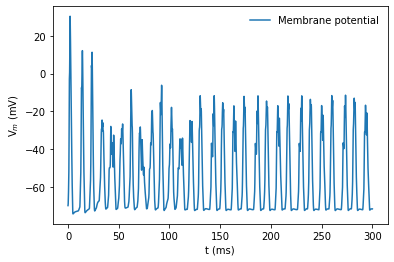

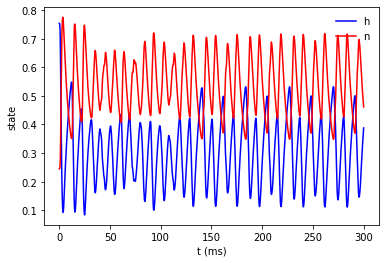

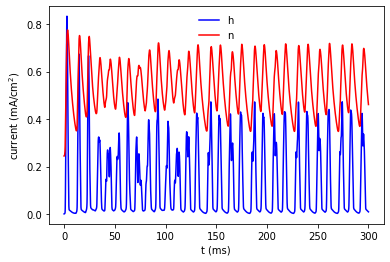

In [ ]:
import numpy as np
from matplotlib import pyplot

vvecAArr=[]
kvecAArr=[]
mvecAArr=[]
hvecAArr=[]
nvecAArr=[]
for i in L1.sets:
    for cell in i.cells:
        checkCell = cell.axon(0.5)
        vvecAArr.append(h.Vector().record(checkCell._ref_v))
        kvecAArr.append(h.Vector().record(checkCell.k_ion._ref_ik))
        # nvecA = h.Vector().record(checkCell.na_ion._ref_ina)
        mvecAArr.append(h.Vector().record(checkCell.hh._ref_m))
        hvecAArr.append(h.Vector().record(checkCell.hh._ref_h))
        nvecAArr.append(h.Vector().record(checkCell.hh._ref_n))

tvec = h.Vector().record(h._ref_t)

h.finitialize(-70)
h.continuerun(300)

vvecMean = np.mean(vvecAArr,axis=0)
hvecMean = np.mean(hvecAArr,axis=0)
nvecMean = np.mean(nvecAArr,axis=0)
kvecMean = np.mean(kvecAArr,axis=0)

fig = pyplot.figure()
pyplot.plot(tvec, vvecMean, label="Membrane potential")
pyplot.xlabel('t (ms)')
pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

fig = pyplot.figure()
pyplot.plot(tvec, hvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('state')
pyplot.legend(frameon=False)


fig = pyplot.figure()
pyplot.plot(tvec, kvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('current (mA/cm$^2$)')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


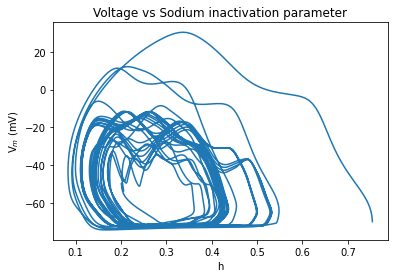

In [ ]:
fig = pyplot.figure()
pyplot.plot(hvecMean, vvecMean, label="")
pyplot.xlabel('h')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Sodium inactivation parameter')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


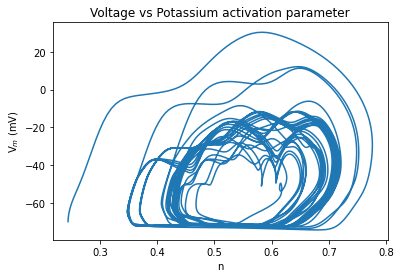

In [ ]:
fig = pyplot.figure()
pyplot.plot(nvecMean, vvecMean, label="")
pyplot.xlabel('n')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Potassium activation parameter')
pyplot.legend(frameon=False)

## Population Activity and weights

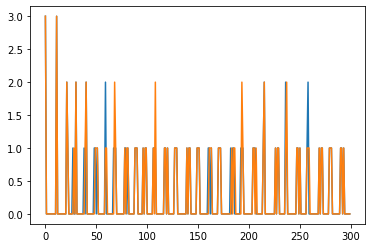

In [ ]:
resolution = 1
import numpy as np
import math
M1_spike_times = [0 for i in range(0,300,resolution)]
M2_spike_times = [0 for i in range(0,300,resolution)]
for cell in L1.sets:
    for i in list(cell.cells[0].spike_times):
        M1_spike_times[math.floor(i)] += 1
    for i in list(cell.cells[1].spike_times):
        M2_spike_times[math.floor(i)] += 1
# M2_spike_times = np.array([list(cell.cells[1].spike_times) for cell in L1.sets])

import matplotlib.pyplot as plt
plt.plot(M1_spike_times)
plt.plot(M2_spike_times)

In [ ]:
print(weight_data1)
print(weight_data3)
print(weight_data5)
print(weight_data2)
print(weight_data4)
print(weight_data6)

[0.5076542215271069, 1.3343031560228846, 2.163426977980106, 2.993290974318544, 3.853189888937809, 4.71312581458788, 5.573098797561471, 6.433182952505623, 7.293489451390899, 8.153833053950313, 9.131986248017055, 9.99244157898634, 10.852822888067791, 11.831345177576024, 12.692022991712278, 13.5528487102824, 14.413675031700782, 15.274612942477328, 16.135587864284677, 16.9965997042476, 17.857574115965896, 18.718548156531334, 19.579596543728798, 20.440570723577984, 21.009947519647216, 21.870958617536175, 22.732340752166515, 23.593759990470993, 24.455253436123744, 25.287119919030488]
[0.389401892917782, 1.2148347257473509, 2.0438105498162376, 2.903190847077077, 3.7629415324022597, 4.62287745805233, 5.482813383702401, 6.342860481323033, 7.203055808237747, 8.063362399824257, 9.070703253934614, 9.931195781337244, 10.791502883012445, 11.799247180177002, 12.659776765019174, 13.52049135796935, 14.174936882483964, 14.829602387722218, 15.484205459189777, 16.345180520106954, 17.206081049105364, 18.06

In [ ]:
# l=[]
# for i in range(len(weight_data1)-1):
#     l.append(abs(weight_data1[i]-weight_data1[i+1]))
# print(l)

In [ ]:
l1=[]
l2=[]
for i in range(size):
  l1.append(L1.sets[i].nc1.weight[0])
  l2.append(L1.sets[i].nc2.weight[0])
print(l1)
print(l2)

[25.287119919030488, 24.956000734803375, 25.528983655268718]
[0.19364810885929462, 0.29598935143725436, 0.23699292116469006]


In [ ]:
sum1=0
sum2=0
list1=[]
list2=[]
for i in range(len(L1.sets)):
  list1.append(list(L1.sets[i].cells[0].spike_times))
  list2.append(list(L1.sets[i].cells[1].spike_times))
  sum1+=len(list1[-1])
  sum2+=len(list2[-1])
print(sum1)
print(sum2)
print(list1)
print(list2)

86
86
[[0.025000000100000003, 11.600000000099875, 22.07500000009928, 30.67500000009879, 40.3000000001006, 49.900000000102786, 68.57500000010702, 81.02500000010986, 90.05000000011191, 99.57500000011407, 108.025000000116, 118.6000000001184, 128.50000000012005, 142.72500000010712, 151.27500000009934, 161.85000000008972, 171.75000000008072, 185.87500000006787, 194.52500000006, 205.1000000000504, 215.00000000004138, 229.02500000002863, 237.77500000002067, 248.35000000001105, 258.25000000000205, 272.1749999999894, 281.02499999998133, 291.5999999999717], [0.025000000100000003, 11.52500000009988, 21.125000000099334, 27.825000000098953, 38.87500000010028, 51.37500000010312, 59.000000000104855, 67.97500000010689, 79.80000000010958, 88.60000000011158, 96.47500000011337, 106.37500000011562, 120.65000000011887, 129.15000000011946, 139.72500000010984, 149.62500000010084, 163.80000000008795, 172.40000000008013, 182.9750000000705, 192.8750000000615, 206.9500000000487, 215.6500000000408, 226.2250000000

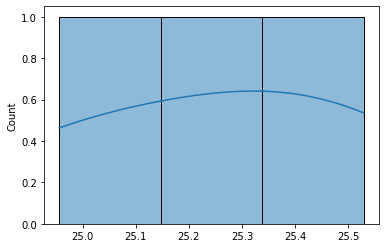

In [ ]:
sb.histplot(l1, kde=True)

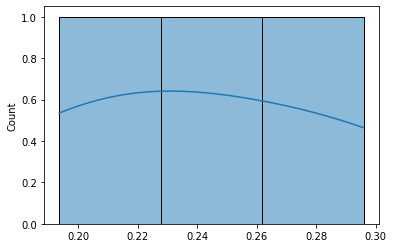

In [ ]:
sb.histplot(l2, kde=True)

In [ ]:
# count, bins, ignored = plt1.hist(weights_rec[0], 10)
# # Plot the distribution curve
# # plt1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),       linewidth=3, color='y')
# plt1.legend(label)
# plt1.xlabel('weights')
# plt1.ylabel('frequency')
# plt1.show()
# print(weights_rec[0])

In [ ]:
# f = plt2.figure(x_axis_label='epoch', y_axis_label='weights')
# x = [i for i in range(len(L_weights_rec[0]))]
# f.line(x, L_weights_rec[3], line_width=1, legend_label='nc11', line_color='blue')
# f.line(x, L_weights_rec_2[0], line_width=2, legend_label='nc12', line_color='red', line_dash='dotted')
# plt2.show(f)

# Raster scan for short intervals

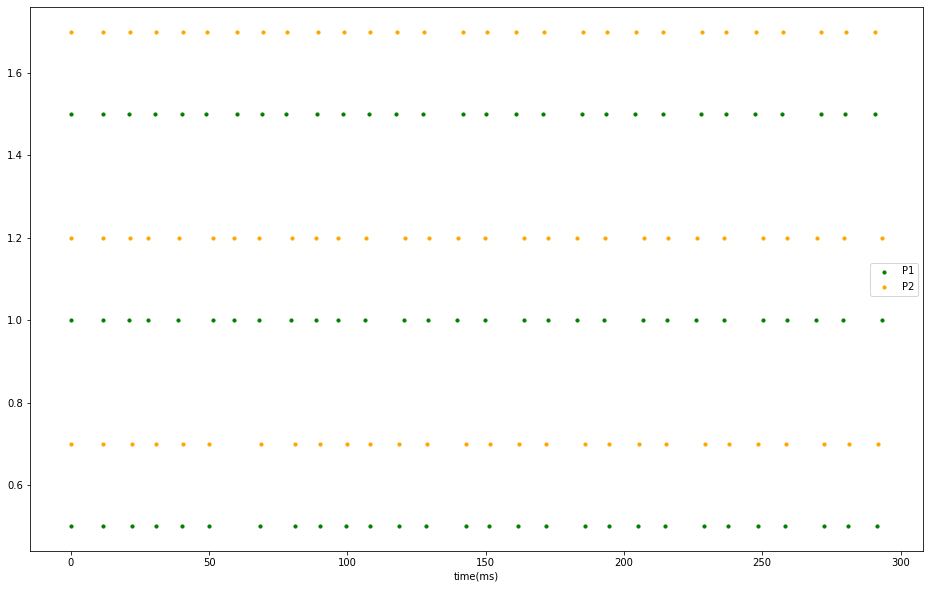

In [ ]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(len(L1.sets)):
  #for i,cell in enumerate(L1.sets[j].cells):
    plt1.scatter(L1.sets[j].cells[0].spike_times, [0.5 + 0.5*j for i in range(len(L1.sets[j].cells[0].spike_times))], s=10,color=color[0]) # for P1
    plt1.scatter(L1.sets[j].cells[1].spike_times, [0.7 + 0.5*j for i in range(len(L1.sets[j].cells[1].spike_times))], s=10, color=color[1])
plt1.xlabel('time(ms)')
plt1.legend(label)

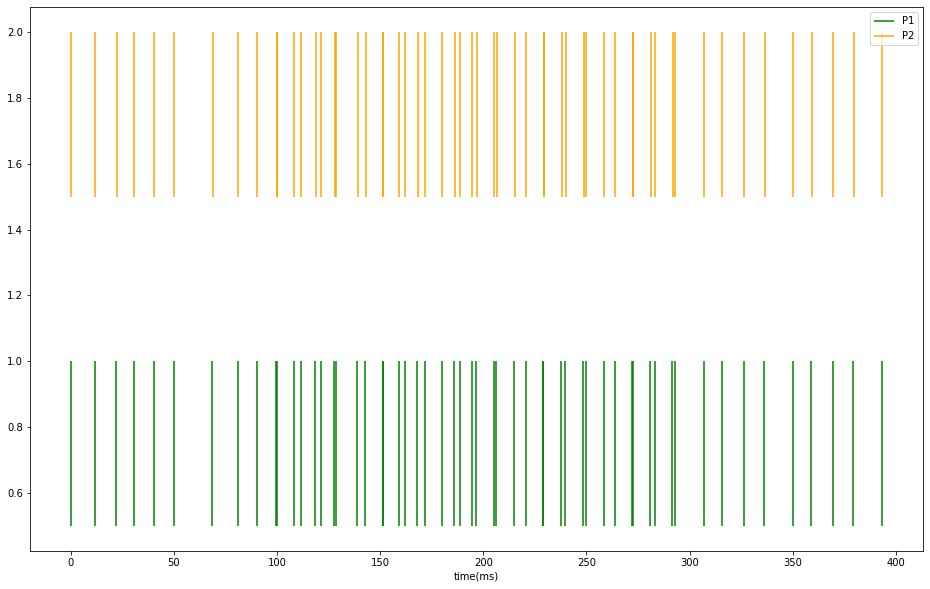

In [ ]:
interval=2 #no.of pairs for each raster scan(if interval is 1 each pair would be displayed individually)
start=0
end=interval
lis=int(size/end)
for k in range(lis):
  color=['green','orange']
  label=['P1','P2']
  plt1.figure(figsize=(16,10))
  for j in range(start,end):
      for i,cell in enumerate(L1.sets[j].cells):
          plt1.vlines(cell.spike_times+(100*j), i + 0.5, i + 1,color=color[i])
  plt1.xlabel('time(ms)')
  plt1.legend(label)
  start=end
  end=end+interval


[0.025000000100000003, 11.600000000099875, 22.07500000009928, 30.67500000009879, 40.3000000001006, 49.900000000102786, 68.57500000010702, 81.02500000010986, 90.05000000011191, 99.57500000011407, 108.025000000116, 118.6000000001184, 128.50000000012005, 142.72500000010712, 151.27500000009934, 161.85000000008972, 171.75000000008072, 185.87500000006787, 194.52500000006, 205.1000000000504, 215.00000000004138, 229.02500000002863, 237.77500000002067, 248.35000000001105, 258.25000000000205, 272.1749999999894, 281.02499999998133, 291.5999999999717]
[0.025000000100000003, 11.600000000099875, 22.07500000009928, 30.67500000009879, 40.3000000001006, 49.900000000102786, 68.57500000010702, 81.02500000010986, 90.05000000011191, 99.57500000011407, 108.025000000116, 118.6000000001184, 128.50000000012005, 142.72500000010712, 151.27500000009934, 161.85000000008972, 171.75000000008072, 185.87500000006787, 194.52500000006, 205.1000000000504, 215.00000000004138, 229.02500000002863, 237.77500000002067, 248.35

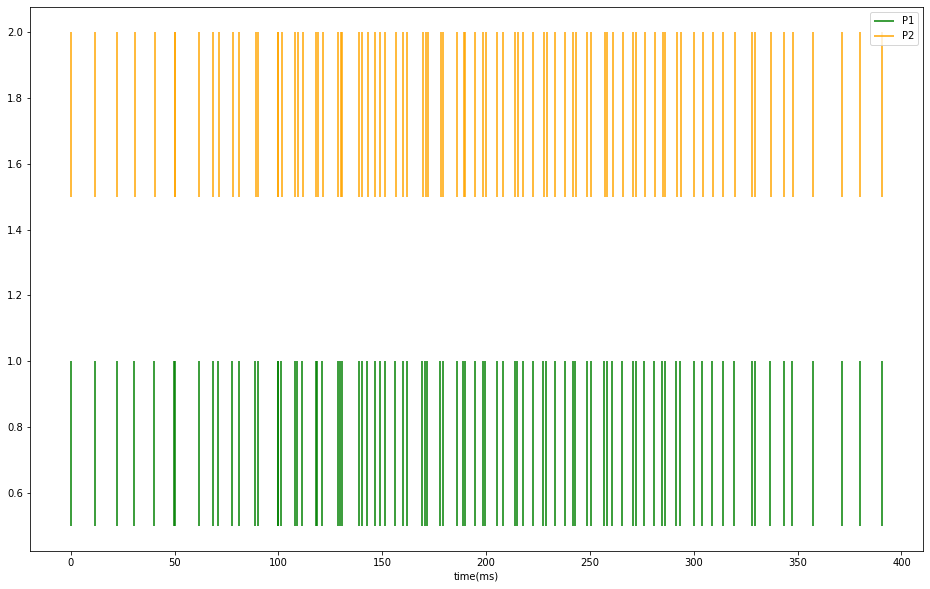

In [ ]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(given_input_from_user):
    for i,cell in enumerate(L1.sets[j].cells):
        plt1.vlines(cell.spike_times+(50*j), i + 0.5, i + 1,color=color[i])
plt1.xlabel('time(ms)')
plt1.legend(label)
t1=list(L1.sets[0].cells[0].spike_times)
t2=list(L1.sets[0].cells[0].spike_times)
print(t1)
print(t2)

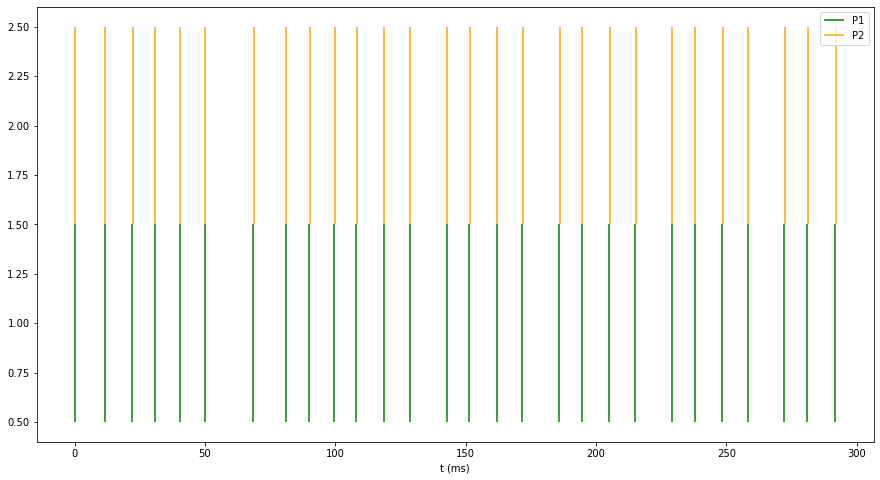

In [ ]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(15,8))
for i,cell in enumerate(L1.sets[0].cells):
    plt1.vlines(cell.spike_times, i + 0.5, i + 1.5,color=color[i],label=label[i])
plt1.xlabel('t (ms)')
plt1.legend()
plt1.show()

In [ ]:
%load_ext google.colab.data_table
import pandas
P1_spike_times = list(L1.sets[0].cells[0].spike_times)
P2_spike_times = list(L1.sets[0].cells[1].spike_times)

padding = len(P1_spike_times) - len(P2_spike_times)
P2_spike_times.extend([0 for i in range(padding)]) if padding > 0 else P1_spike_times.extend([0 for i in range(-padding)])
# print(len(P1_spike_times), len(P2_spike_times))
data = {'P1 before learning': P1_spike_times, 'P2 before learning' : P2_spike_times}
pandas.DataFrame(data)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,P1 before learning,P2 before learning
0,0.025,0.025
1,11.600,11.800
2,22.075,22.275
3,30.675,30.875
4,40.300,40.525
5,49.900,50.100
6,68.575,68.725
7,81.025,81.225
8,90.050,90.250
9,99.575,99.800


### **A_plus and A_minus**

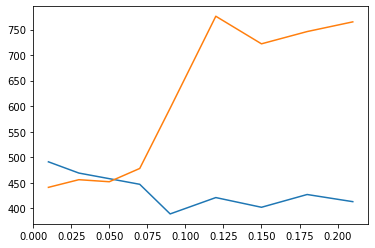

In [ ]:
a_plus_val=[0.01,0.03,0.05,0.07,0.09,0.12,0.15,0.18,0.21]
p1_spikes = [491,469,458,447,389,421,402,427,413]
p2_spikes = [441,456,452,478,596,776,722,746,765]
pyplot.plot(a_plus_val, p1_spikes)
pyplot.plot(a_plus_val, p2_spikes)

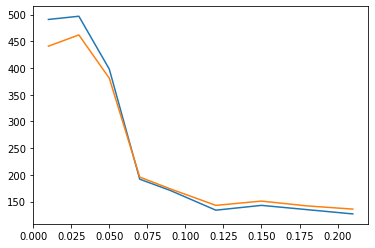

In [ ]:
a_minus_val= [-0.0011,-0.0022,-0.0033,-0.0044,-0.0055,-0.0066,-0.0077,-0.0088,-0.0099]
P1_spikes = [491,497,398,192,171,134,143,135,127]
P2_spikes = [441,462,381,196,174,143,151,142,136]
pyplot.plot(a_plus_val, P1_spikes)
pyplot.plot(a_plus_val, P2_spikes)